# Numba

## Example Use Case

Simulation of Casino visits playing roulette. A stop-loss amount (money carried with you), a stop-win amount (when you take the won money and leave) and a maximum number of games per visit (when you stop playing even if neither stop-loss nor stop-win is reached) can be configured.

Main assumption:
Constant bet of 1 unit per game (no increase/ decrease of bets during casino visit)


The calculation of the casino visit profit/ loss cannot be vectorized efficiently to use numpy due to the stop conditions.
The alternative would be to simulate max_games for each series, which is inefficient because a stop condition could be reached much earlier.

## Used Functionalities

* Numpy
* Numba just-in-time compiler
* matplotlib for plotting results


## Code

In [1]:
import numpy as np
from matplotlib import pyplot
from numba import jit

In [12]:
@jit
def game(game_type):
    """
    A single roulette game.
    Returns profit or loss of this game.
    """
    nr = np.random.randint(0,36+1)
    if game_type == 1: #black/white, etc.
        if 0 < nr <= 18:
            return 2 - 1
    elif game_type == 2: #3 choices
        if 0 < nr <= 12:
            return 3 - 1
    elif game_type == 3: #single number
        if nr == 1:
            return 36 - 1
    return 0 - 1

@jit
def game_series(game_type, stop_loss, stop_win, max_games=100):
    """
    A series of roulette games, corresponding to a casino visit.
    The series ends if either stop-loss, stop-win or max games is reached.
    Returns profit or loss of the casino visit.
    """
    assert stop_loss < 0
    assert stop_win > 0
    assert max_games > 0
    assert game_type in (1, 2, 3)
    
    # this calculation cannot be vectorized efficiently to use numpy due to the stop conditions
    # the alternative would be to simulate max_games for each series, which is inefficient
    # because a stop condition could be reached much earlier
    pocket = 0
    for i in range(max_games):
        pocket += game(game_type)
        if pocket <= stop_loss or pocket >= stop_win:
            break
    return pocket

def series_stats(game_type, stop_loss, stop_win, max_games, simulations=1000000):
    """
    Simulates a large number (up to millions) of casino visits and calculates statistical 
    properties of the p&l.
    """
    runs = np.array([game_series(game_type, stop_loss, stop_win, max_games) 
                     for i in range(simulations)])
    bins, counts = np.unique(runs, return_counts=True)
    return {
        'mean': np.mean(runs),
        'stddev': np.std(runs),
        'bins': bins,
        'counts': counts/simulations,
        'gain': (runs > 0).sum()/simulations,
        }

In [13]:
stats = series_stats(game_type=1, stop_loss=-10, stop_win=10, max_games=50)
stats

{'mean': -1.19262,
 'stddev': 6.618188387738747,
 'bins': array([-10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10]),
 'counts': array([0.207929, 0.039986, 0.072809, 0.094842, 0.106277, 0.105965,
        0.095417, 0.076984, 0.052346, 0.025981, 0.121464]),
 'gain': 0.372192}

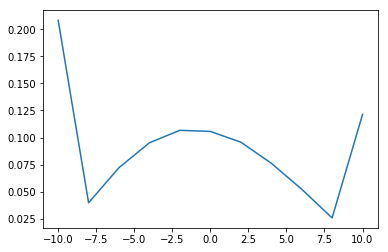

In [9]:
pyplot.plot(stats['bins'], stats['counts'])

## Calculation Time

In [7]:
%timeit series_stats(game_type=1, stop_loss=-10, stop_win=10, max_games=50, simulations=10000)

36.6 ms ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
def game_no_jit(game_type):
    """
    A single roulette game.
    Returns profit or loss of this game.
    """
    nr = np.random.randint(0,36+1)
    if game_type == 1: #black/white, etc.
        if 0 < nr <= 18:
            return 2 - 1
    elif game_type == 2: #3 choices
        if 0 < nr <= 12:
            return 3 - 1
    elif game_type == 3: #single number
        if nr == 1:
            return 36 - 1
    return 0 - 1

def game_series_no_jit(game_type, stop_loss, stop_win, max_games=100):
    """
    A series of roulette games, corresponding to a casino visit.
    The series ends if either stop-loss, stop-win or max games is reached.
    Returns profit or loss of the casino visit.
    """
    assert stop_loss < 0
    assert stop_win > 0
    assert max_games > 0
    assert game_type in (1, 2, 3)
    
    # this calculation cannot be vectorized efficiently to use numpy due to the stop conditions
    # the alternative would be to simulate max_games for each series, which is inefficient
    # because a stop condition could be reached much earlier
    pocket = 0
    for i in range(max_games):
        pocket += game_no_jit(game_type)
        if pocket <= stop_loss or pocket >= stop_win:
            break
    return pocket

def series_stats_no_jit(game_type, stop_loss, stop_win, max_games, simulations=1000000):
    """
    Simulates a large number (up to millions) of casino visits and calculates statistical 
    properties of the p&l.
    """
    runs = np.array([game_series_no_jit(game_type, stop_loss, stop_win, max_games) 
                     for i in range(simulations)])
    bins, counts = np.unique(runs, return_counts=True)
    return {
        'mean': np.mean(runs),
        'stddev': np.std(runs),
        'bins': bins,
        'counts': counts/simulations,
        'gain': (runs > 0).sum()/simulations,
        }

In [17]:
%timeit series_stats_no_jit(game_type=1, stop_loss=-10, stop_win=10, max_games=50, simulations=10000)

2.85 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The numba just-in-time compiler gives a speedup of nearly a factor 100 (about a factor of 10 is gained both by jit compilation of game() and game_series()).

Suggestion: for large numerical calculations, use vectorized numpy operations wherever possible. If large loops cannot be avoided, use the numba jit compiler.